In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import train_test_split
import random
from sklearn.metrics import log_loss
from math import exp
import xgboost as xgb
from XGBoostPackage import xgbClass
from CrossValidation import CVScore
# from difflib import SequenceMatcher
import editdistance
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import time
%matplotlib inline
%pylab inline
sns.set_style("whitegrid")
from sklearn import preprocessing

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'exp']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [9]:
X_train = pd.read_json("../input/train.json")
X_test = pd.read_json("../input/test.json")


In [10]:
interest_level_map = {'low': 0, 'medium': 1, 'high': 2}
X_train['interest_level'] = X_train['interest_level'].apply(lambda x: interest_level_map[x])
X_test['interest_level'] = -1

In [11]:
image_date = pd.read_csv("../input/listing_image_time.csv")

# rename columns so you can join tables later on
image_date.columns = ["listing_id", "time_stamp"]

# reassign the only one timestamp from April, all others from Oct/Nov
image_date.loc[80240,"time_stamp"] = 1478129766 

image_date["img_date"]                  = pd.to_datetime(image_date["time_stamp"], unit="s")
image_date["img_days_passed"]           = (image_date["img_date"].max() - image_date["img_date"]).astype("timedelta64[D]").astype(int)
image_date["img_date_month"]            = image_date["img_date"].dt.month
image_date["img_date_week"]             = image_date["img_date"].dt.week
image_date["img_date_day"]              = image_date["img_date"].dt.day
image_date["img_date_dayofweek"]        = image_date["img_date"].dt.dayofweek
image_date["img_date_dayofyear"]        = image_date["img_date"].dt.dayofyear
image_date["img_date_hour"]             = image_date["img_date"].dt.hour
image_date["img_date_monthBeginMidEnd"] = image_date["img_date_day"].apply(lambda x: 1 if x<10 else 2 if x<20 else 3)

X_train = pd.merge(X_train, image_date, on="listing_id", how="left")
X_test = pd.merge(X_test, image_date, on="listing_id", how="left")

In [17]:
X_train[X_train.columns[-15:]].head()

,longitude,manager_id,photos,price,street_address,time_stamp,img_date,img_days_passed,img_date_month,img_date_week,img_date_day,img_date_dayofweek,img_date_dayofyear,img_date_hour,img_date_monthBeginMidEnd
0,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,1478091590,2016-11-02 12:59:50,19,11,44,2,2,307,12,1
1,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,1478129766,2016-11-02 23:36:06,19,11,44,2,2,307,23,1
2,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,1478714436,2016-11-09 18:00:36,12,11,45,9,2,314,18,1
3,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,1478714444,2016-11-09 18:00:44,12,11,45,9,2,314,18,1
4,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,1478714464,2016-11-09 18:01:04,12,11,45,9,2,314,18,1


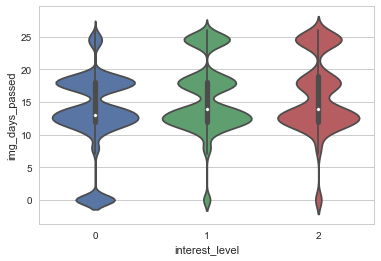

In [12]:
sns.violinplot(x='interest_level',y='img_days_passed',data=X_train)

(4129, 2368)


(0, 4)

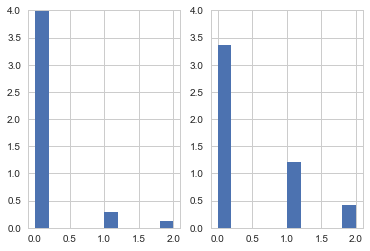

In [64]:
print(sum(X_train['img_days_passed']==0),sum(X_train['img_days_passed']==25))
plt.subplot(121)
X_train[X_train['img_days_passed']==0]['interest_level'].hist(normed=1)
pylab.ylim([0,4])
plt.subplot(122)
X_train[X_train['img_days_passed']!=0]['interest_level'].hist(normed=1)
pylab.ylim([0,4])

(0, 4)

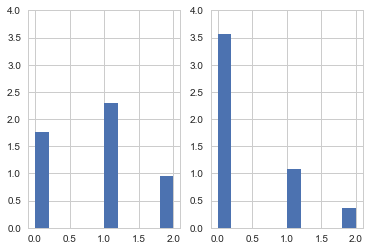

In [65]:
plt.subplot(121)
X_train[X_train['img_days_passed']==25]['interest_level'].hist(normed=1)
pylab.ylim([0,4])
plt.subplot(122)
X_train[X_train['img_days_passed']!=25]['interest_level'].hist(normed=1)
pylab.ylim([0,4])

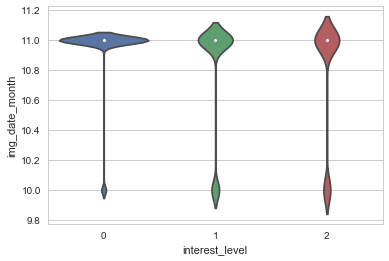

In [13]:
sns.violinplot(x='interest_level',y='img_date_month',data=X_train)

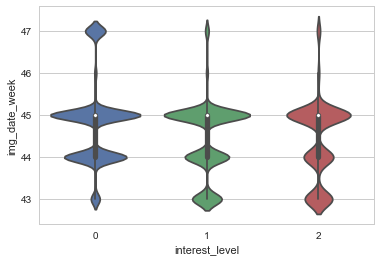

In [52]:
sns.violinplot(x='interest_level',y='img_date_week',data=X_train)

(4129, 4506)


(0, 4)

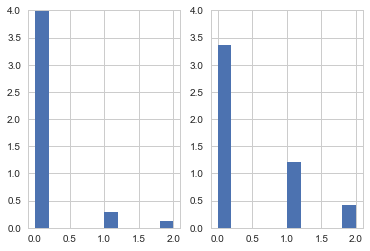

In [62]:
print(sum(X_train['img_date_week']==47),sum(X_train['img_date_week']==43))
plt.subplot(121)
X_train[X_train['img_date_week']==47]['interest_level'].hist(normed=1)
pylab.ylim([0,4])
plt.subplot(122)
X_train[X_train['img_date_week']!=47]['interest_level'].hist(normed=1)
pylab.ylim([0,4])

(0, 4)

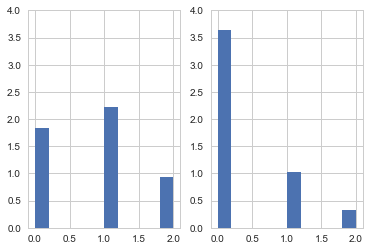

In [63]:
plt.subplot(121)
X_train[X_train['img_date_week']==43]['interest_level'].hist(normed=1)
pylab.ylim([0,4])
plt.subplot(122)
X_train[X_train['img_date_week']!=43]['interest_level'].hist(normed=1)
pylab.ylim([0,4])

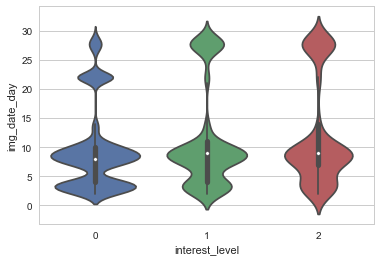

In [14]:
sns.violinplot(x='interest_level',y='img_date_day',data=X_train)

(3955, 2262)


(0, 4)

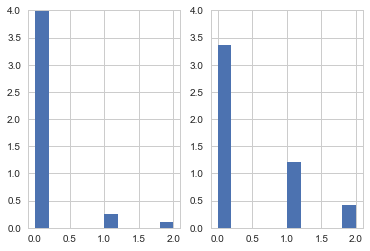

In [58]:
print(sum(X_train['img_date_day']==22),sum(X_train['img_date_day']==28))
plt.subplot(121)
X_train[X_train['img_date_day']==22]['interest_level'].hist(normed=1)
pylab.ylim([0,4])
plt.subplot(122)
X_train[X_train['img_date_day']!=22]['interest_level'].hist(normed=1)
pylab.ylim([0,4])

(0, 4)

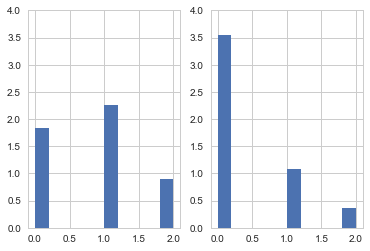

In [59]:
plt.subplot(121)
X_train[X_train['img_date_day']==28]['interest_level'].hist(normed=1)
pylab.ylim([0,4])
plt.subplot(122)
X_train[X_train['img_date_day']!=28]['interest_level'].hist(normed=1)
pylab.ylim([0,4])

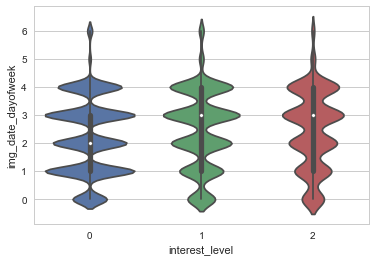

In [18]:
sns.violinplot(x='interest_level',y="img_date_dayofweek",data=X_train)

In [69]:
X_train['img_date_dayofyear'].describe()

count    49352.000000
mean       312.075823
std          6.019149
min        300.000000
25%        308.000000
50%        313.000000
75%        314.000000
max        327.000000
Name: img_date_dayofyear, dtype: float64

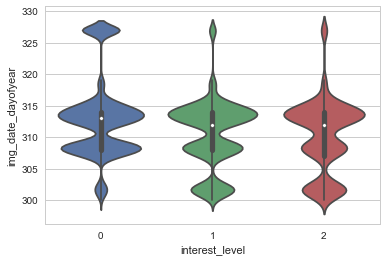

In [19]:
sns.violinplot(x='interest_level',y="img_date_dayofyear",data=X_train)

4506


(0, 4)

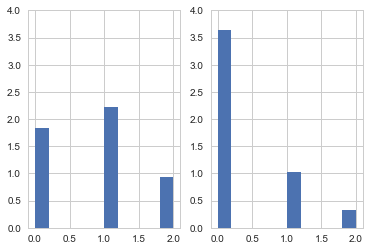

In [67]:
print(sum(X_train['img_date_dayofyear']<305))
plt.subplot(121)
X_train[X_train['img_date_dayofyear']<305]['interest_level'].hist(normed=1)
pylab.ylim([0,4])
plt.subplot(122)
X_train[X_train['img_date_dayofyear']>=305]['interest_level'].hist(normed=1)
pylab.ylim([0,4])

4129


(0, 4)

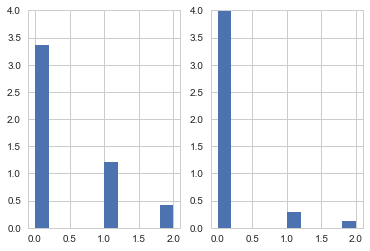

In [70]:
print(sum(X_train['img_date_dayofyear']>=325))
plt.subplot(121)
X_train[X_train['img_date_dayofyear']<=325]['interest_level'].hist(normed=1)
pylab.ylim([0,4])
plt.subplot(122)
X_train[X_train['img_date_dayofyear']>325]['interest_level'].hist(normed=1)
pylab.ylim([0,4])

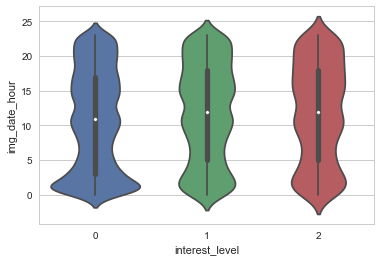

In [20]:
sns.violinplot(x='interest_level',y="img_date_hour",data=X_train)

(0, 4)

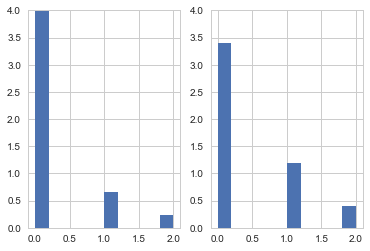

In [66]:
plt.subplot(121)
X_train[X_train['img_date_hour']==1]['interest_level'].hist(normed=1)
pylab.ylim([0,4])
plt.subplot(122)
X_train[X_train['img_date_hour']!=1]['interest_level'].hist(normed=1)
pylab.ylim([0,4])

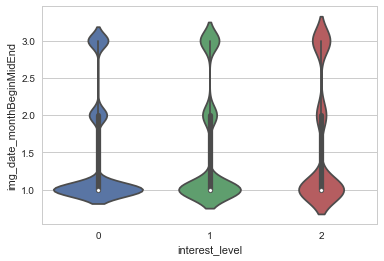

In [21]:
sns.violinplot(x='interest_level',y="img_date_monthBeginMidEnd",data=X_train)

(0, 4)

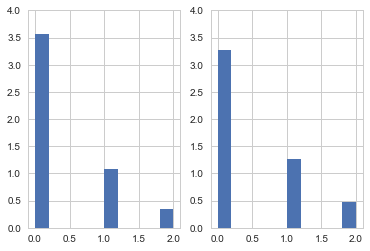

In [44]:
plt.subplot(121)
X_train[X_train['img_date_monthBeginMidEnd']==1]['interest_level'].hist(normed=1)
pylab.ylim([0,4])
plt.subplot(122)
X_train[X_train['img_date_monthBeginMidEnd']!=1]['interest_level'].hist(normed=1)
pylab.ylim([0,4])

(0, 4)

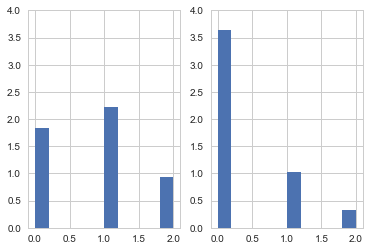

In [51]:
plt.subplot(121)
X_train[X_train['img_date_month']==10]['interest_level'].hist(normed=1)
pylab.ylim([0,4])
plt.subplot(122)
X_train[X_train['img_date_month']==11]['interest_level'].hist(normed=1)
pylab.ylim([0,4])